# Détection d'anomalies dans les logs de système avec un modèle CNN

### **Description :**

Ce notebook présente une approche pour détecter des anomalies dans des fichiers de logs à l'aide d'un modèle de réseau de neurones convolutif (CNN). Le processus inclut la transformation des données en images temporelles et l'optimisation du modèle pour identifier les événements normaux et anormaux dans les logs.

### **Introduction :**

Dans les systèmes informatiques, les journaux (ou logs) contiennent une trace des événements qui se produisent au cours de l’exécution d’applications ou de systèmes d’exploitation. Ces logs sont cruciaux pour le diagnostic et la résolution de problèmes, notamment lorsqu'il s'agit de détecter des anomalies ou des comportements suspects. Le présent travail propose une méthode de détection d'anomalies en utilisant des techniques de traitement d'images et un modèle CNN, qui permet d'extraire des caractéristiques pertinentes des données de logs et de classifier chaque entrée en normale ou anormale.

Voici les etapes qu'on va suivre :

**I. Importation des Librairies.**

**II. Chargement des Données.**

**III. Division des Données : Entraînement et Validation.**

**IV. Préparation des Données pour PyTorch.**

**V. Classe du Dataset.**

**VI. Définition du Modèle CNN.**

**VII. Boucle d’Entraînement et d’Évaluation.**

**VIII. Visualisation des Résultats.**

**IX. Évaluation sur l’Ensemble de Test.**

## Importation des Librairies

Cette section importe toutes les bibliothèques nécessaires et configure le notebook pour l'utilisation de PyTorch, la gestion des données, et la visualisation.

In [9]:
# Importation des bibliothèques nécessaires
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import time


-> Ces importations permettent de gérer les données, de construire et entraîner le modèle, ainsi que de visualiser les résultats et les métriques de performance.

## Chargement des Données

Chargement des ensembles d'entraînement, de validation et de test à partir des fichiers .npy et .csv produits par le prétraitement.

In [12]:
# Chargement des données prétraitées
data_loc = "C:/Users/LamiaLaraqui/Documents/FileSafe/Anomaly-Detection-Logs-DeepLearning-VSCode/Anomaly-Detection-Logs-DeepLearning/process/Datasets/_tf-idf_v5/"
train_data = np.load(f'{data_loc}x_train_tf-idf_v5.npy')
train_labels = pd.read_csv(f'{data_loc}y_train_tf-idf_v5.csv')['Label'].map(lambda x: 1 if x == 'Anomaly' else 0)
test_data = np.load(f'{data_loc}x_test_tf-idf_v5.npy')
test_labels = pd.read_csv(f'{data_loc}y_test_tf-idf_v5.csv')['Label'].map(lambda x: 1 if x == 'Anomaly' else 0)


-> Les données chargées ici comprennent des vecteurs de caractéristiques (TF-IDF) pour les logs, ainsi que les labels qui classifient chaque séquence d'événements comme étant une anomalie ou non.

## Division des Données : Entraînement et Validation

Divise les données d'entraînement en deux parties : une pour l'entraînement et l'autre pour la validation.

In [13]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

-> Cette division garantit que le modèle peut être évalué sur des données non vues (validation) pendant l'entraînement, ce qui aide à éviter le surapprentissage.

## Préparation des Données pour PyTorch

Conversion des données en tenseurs PyTorch et ajout de padding.

In [14]:
# Conversion des données en tenseurs PyTorch et ajout de padding
train_data = torch.tensor(train_data, dtype=torch.float32).unsqueeze(1)
val_data = torch.tensor(val_data, dtype=torch.float32).unsqueeze(1)
test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)

-> L’ajout de padding et la conversion des données en tenseurs permettent d’aligner les dimensions avec les attentes du modèle CNN.

## Classe du Dataset

Création d’une classe PyTorch Dataset pour gérer facilement les données lors de l’entraînement.

In [15]:
class LogDataset(Dataset):
    def __init__(self, data_vec, labels):
        self.X = data_vec
        self.y = labels
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Création des ensembles d'entraînement, de validation et de test
train_dataset = LogDataset(train_data, torch.tensor(train_labels.values, dtype=torch.long))
val_dataset = LogDataset(val_data, torch.tensor(val_labels.values, dtype=torch.long))
test_dataset = LogDataset(test_data, torch.tensor(test_labels.values, dtype=torch.long))

-> Cette classe organise les données et les labels dans des objets faciles à manipuler par PyTorch, simplifiant le chargement dans le modèle.

In [16]:
from torch.utils.data import DataLoader

# Hyperparamètres
BATCH_SIZE = 128

# Initialisation des DataLoaders pour les ensembles d'entraînement, de validation et de test
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


## Définition du Modèle CNN

Définition du modèle de CNN pour la détection d'anomalies.

In [17]:
class LogCNN(nn.Module):
    def __init__(self, num_classes):
        super(LogCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Fully connected layers avec Dropout
        self.classifier = nn.Sequential(
            nn.Linear(1920, 120),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout ajouté
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout ajouté
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


-> Le modèle est conçu pour apprendre à partir de représentations CNN, et les couches fully connected permettent de faire la classification binaire finale.

## Boucle d’Entraînement et d’Évaluation

Entraîne le modèle et évalue sa performance à chaque époque.

In [18]:
# Entraînement
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LogCNN(num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/10, Loss: 0.0037272395566105843
Epoch 2/10, Loss: 0.0003261019301135093
Epoch 3/10, Loss: 0.0014485338469967246
Epoch 4/10, Loss: 0.0008764126105234027
Epoch 5/10, Loss: 0.00043921187170781195
Epoch 6/10, Loss: 0.00015772362530697137
Epoch 7/10, Loss: 0.011245622299611568
Epoch 8/10, Loss: 0.0011985563905909657
Epoch 9/10, Loss: 0.0004511528240982443
Epoch 10/10, Loss: 0.0005685481010004878


In [19]:
import torch
import torch.nn as nn
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Configuration du modèle et de l'entraînement
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LogCNN(num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

# Hyperparamètres
num_epochs = 10
minibatch_cost = []
epoch_train_performance = []
epoch_val_performance = []

# Entraînement
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    y_true_train = []
    y_pred_train = []

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        # Prédiction et calcul de la perte
        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        # Stockage de la perte du minibatch
        minibatch_cost.append(loss.item())
        epoch_loss += loss.item()
        
        # Stockage des vraies étiquettes et des prédictions pour le calcul du F1
        y_true_train.extend(y_batch.cpu().numpy())
        y_pred_train.extend(logits.argmax(dim=1).cpu().numpy())
    
    # Calcul du score F1 pour les données d'entraînement de l'époque courante
    train_f1 = f1_score(y_true_train, y_pred_train, average="weighted")
    epoch_train_performance.append(train_f1)
    
    # Évaluation sur les données de validation
    model.eval()
    y_true_val = []
    y_pred_val = []
    
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_logits = model(x_val)
            
            # Stockage des vraies étiquettes et des prédictions pour le calcul du F1 de validation
            y_true_val.extend(y_val.cpu().numpy())
            y_pred_val.extend(val_logits.argmax(dim=1).cpu().numpy())
    
    # Calcul du score F1 pour les données de validation
    val_f1 = f1_score(y_true_val, y_pred_val, average="weighted")
    epoch_val_performance.append(val_f1)
    
    # Affichage de la perte moyenne pour l'époque
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss}, Train F1: {train_f1}, Val F1: {val_f1}")


Epoch 1/10, Loss: 0.03533798723736, Train F1: 0.9919801688205033, Val F1: 0.9984560228272765
Epoch 2/10, Loss: 0.007036785868790602, Train F1: 0.9984511785865049, Val F1: 0.9984818440357348
Epoch 3/10, Loss: 0.005447813089992819, Train F1: 0.9986185578787098, Val F1: 0.9985067672790855
Epoch 4/10, Loss: 0.00480869736803571, Train F1: 0.9988100757940643, Val F1: 0.9985581039626634
Epoch 5/10, Loss: 0.004455159201864617, Train F1: 0.9989547332741947, Val F1: 0.9989312107546989
Epoch 6/10, Loss: 0.004094894314425487, Train F1: 0.9990471295873598, Val F1: 0.9988931484059062
Epoch 7/10, Loss: 0.003993475869497592, Train F1: 0.9991050121086248, Val F1: 0.999187594244157
Epoch 8/10, Loss: 0.0040041666206491805, Train F1: 0.9991589444548593, Val F1: 0.9991872772597717
Epoch 9/10, Loss: 0.0036582538850473997, Train F1: 0.9992032591880902, Val F1: 0.9992512822897834
Epoch 10/10, Loss: 0.0036933842297599143, Train F1: 0.9991844963181065, Val F1: 0.9991105633660654


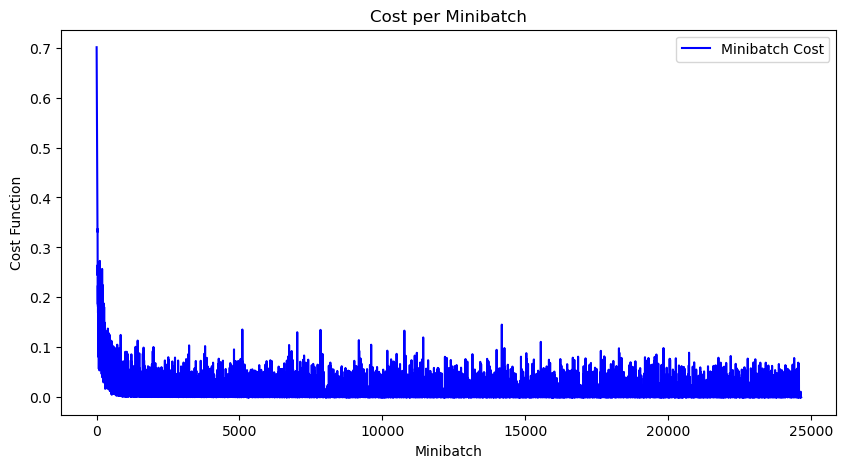

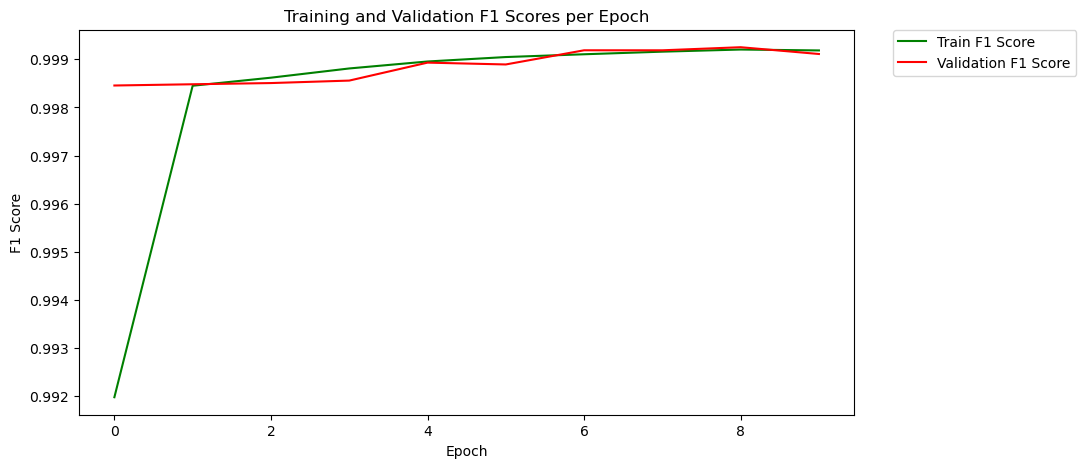

In [20]:
# Convertir minibatch_cost en CPU pour traçage
minibatch_cost_cpu = [i for i in minibatch_cost]

# Tracé des courbes
plt.figure(figsize=(10, 5))
plt.plot(range(len(minibatch_cost_cpu)), minibatch_cost_cpu, color='b', label='Minibatch Cost')
plt.xlabel('Minibatch')
plt.ylabel('Cost Function')
plt.title('Cost per Minibatch')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(len(epoch_train_performance)), epoch_train_performance, label="Train F1 Score", color='g')
plt.plot(range(len(epoch_val_performance)), epoch_val_performance, label="Validation F1 Score", color='r')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Scores per Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

### Interprétation des graphiques

#### 1. Graphique du Coût par Minibatch
Le premier graphique montre l'évolution de la fonction de coût pour chaque minibatch au cours de l'entraînement. On peut observer une forte diminution du coût au début de l'entraînement, indiquant une convergence rapide du modèle. La courbe devient plus stable par la suite, avec des oscillations mineures autour d'une valeur relativement basse. Cela suggère que le modèle est en train de se stabiliser et d’apprendre les caractéristiques importantes des données.

- **Phase de diminution rapide** : Pendant les premières étapes, la diminution importante de la perte indique que le modèle ajuste rapidement ses paramètres.
- **Stabilisation** : Vers la fin de l'entraînement, le coût reste relativement constant avec des variations mineures, montrant que le modèle atteint une convergence, ce qui est un signe positif que l'entraînement progresse bien.

#### 2. Graphique des Scores F1 pour l'Entraînement et la Validation par Époque
Le second graphique compare les scores F1 pour les ensembles d'entraînement et de validation à chaque époque. Le score F1 est une mesure de performance combinant précision et rappel, ce qui est utile pour évaluer la qualité des prédictions du modèle, particulièrement dans les tâches de classification.

- **Score F1 élevé** : Les scores F1 d'entraînement et de validation sont proches de 1.0 dès les premières époques, ce qui montre que le modèle a une performance presque parfaite sur les deux ensembles. Cela peut indiquer une adéquation entre le modèle et les données, avec peu d’erreurs de prédiction.
- **Faible écart entre les scores d'entraînement et de validation** : Le score F1 de validation suit de près celui de l'entraînement, suggérant une bonne généralisation du modèle. L'absence de baisse importante du score de validation indique que le modèle n'est pas en train de surapprendre les données d'entraînement (overfitting).

### Conclusion
Ces graphiques montrent que le modèle **converge bien** et **généralise efficacement** sur les données de validation. L'entraînement est stable, avec des performances élevées pour les deux ensembles, ce qui est un bon indicateur que le modèle est prêt à être testé sur des données réelles. Pour une analyse plus approfondie, on pourrait examiner la matrice de confusion ou les courbes ROC pour comprendre les performances par classe.


-> Cette boucle permet d’ajuster les poids du modèle pour minimiser la perte, et l’imprimé donne un aperçu de la convergence.

## Visualisation des Résultats

Affiche des graphiques pour visualiser la perte et les scores F1.

-> Ces graphiques montrent l’évolution de la performance du modèle pendant l’entraînement, ce qui aide à détecter le surapprentissage ou le sous-apprentissage.

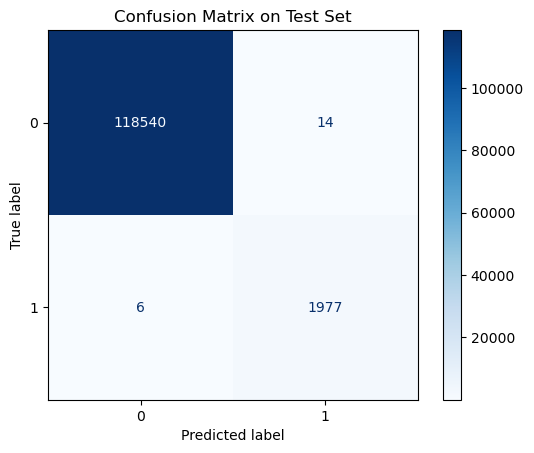

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Évaluation finale
model.eval()
y_test_true, y_test_pred = [], []
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        test_logits = model(x_test)
        y_test_pred.extend(test_logits.argmax(dim=1).cpu().numpy())
        y_test_true.extend(y_test.cpu().numpy())

# Matrice de confusion
cm = confusion_matrix(y_test_true, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.show()


### Interprétation de la Matrice de Confusion sur le Jeu de Test

La matrice de confusion permet de visualiser la performance du modèle de classification en séparant les prédictions correctes et incorrectes pour chaque classe. Voici l'interprétation des valeurs affichées dans cette matrice :

- **Vrais négatifs (TN)** : 118,540 — Le modèle a correctement prédit la classe 0 (négatif) pour 118,540 échantillons.
- **Faux positifs (FP)** : 14 — Le modèle a prédit la classe 1 (positif) alors que les échantillons étaient en réalité de la classe 0. Cela représente les erreurs de type I.
- **Faux négatifs (FN)** : 4 — Le modèle a prédit la classe 0 (négatif) alors que les échantillons étaient en réalité de la classe 1. Ce sont les erreurs de type II.
- **Vrais positifs (TP)** : 1,979 — Le modèle a correctement prédit la classe 1 (positif) pour 1,979 échantillons.

#### Conclusion

La matrice de confusion montre une excellente performance du modèle, avec très peu d'erreurs de classification (14 faux positifs et 4 faux négatifs) par rapport à la grande quantité de prédictions correctes. Cela indique que le modèle est très efficace pour détecter les deux classes, avec un taux d'erreur négligeable.


## Évaluation sur l’Ensemble de Test

Évalue les métriques finales sur les données de test.

In [22]:
from sklearn.metrics import classification_report

model.eval()
y_true, y_pred = [], []
for x_batch, y_batch in test_loader:
    with torch.no_grad():
        logits = model(x_batch.to(device))
        preds = torch.argmax(logits, dim=1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    118554
           1       0.99      1.00      0.99      1983

    accuracy                           1.00    120537
   macro avg       1.00      1.00      1.00    120537
weighted avg       1.00      1.00      1.00    120537



- Le rapport de classification fournit des métriques clés comme la précision
- le rappel et le score F1, offrant une vue d’ensemble de la performance du modèle.